In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import HuberRegressor
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
import matplotlib.dates as mdates
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import gc
from sklearn import ensemble
import seaborn as sns 
from functools import reduce



In [2]:
df_final = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/The complete dataframe/df_final_cleaned_combined_2_endofmonth.csv")

df_final['Adj Close t+1'] = df_final.groupby("Symbol")["Adj Close"].shift(-1)

df_final = df_final.dropna(subset=['Adj Close t+1']).reset_index(drop=True)

df_final = df_final[df_final['1-month momentum'] != 0]

df_final['Date'] = pd.to_datetime(df_final['Date'])

df_final = df_final.sort_values(by='Date').reset_index(drop=True)

df_final = df_final[df_final['Adj Close t+1'] <= df_final["Adj Close t+1"].quantile(0.985)]



variables = ['Adj Close t+1', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Market capitalization', 'Revenue', 'Earnings',
       'P/E ratio', 'P/B ratio', 'Operating Margin', 'EPS',
       'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
       'Cash on Hand', 'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size']

df_final[variables] = df_final[variables].replace([np.inf, -np.inf], np.nan)

non_negative_variables = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
    'Stock Splits', 'Market capitalization', 'Revenue', 'EPS',
    'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
    'Cash on Hand', 'Net assets'
]

df_final[non_negative_variables] = df_final[non_negative_variables].applymap(lambda x: max(x, 0))


funda_cols = [
    'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 'P/B ratio',
    'Operating Margin', 'EPS', 'Shares Outstanding', 'Total assets',
    'Total liabilities', 'Total debt', 'Cash on Hand', 'Net assets'
]

df_final[funda_cols] = (
    df_final.groupby('Symbol')[funda_cols]
      .shift(12))

df_final = df_final.dropna(subset=variables).reset_index(drop=True)



In [3]:
# Create the top and bottom firms by market cap:

top_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nlargest(500)  
    .index 
)


df_top_500 = df_final[df_final['Symbol'].isin(top_symbols)].reset_index(drop=True)



bottom_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nsmallest(500)  
    .index 
)


df_bottom_500 = df_final[df_final['Symbol'].isin(bottom_symbols)].reset_index(drop=True)

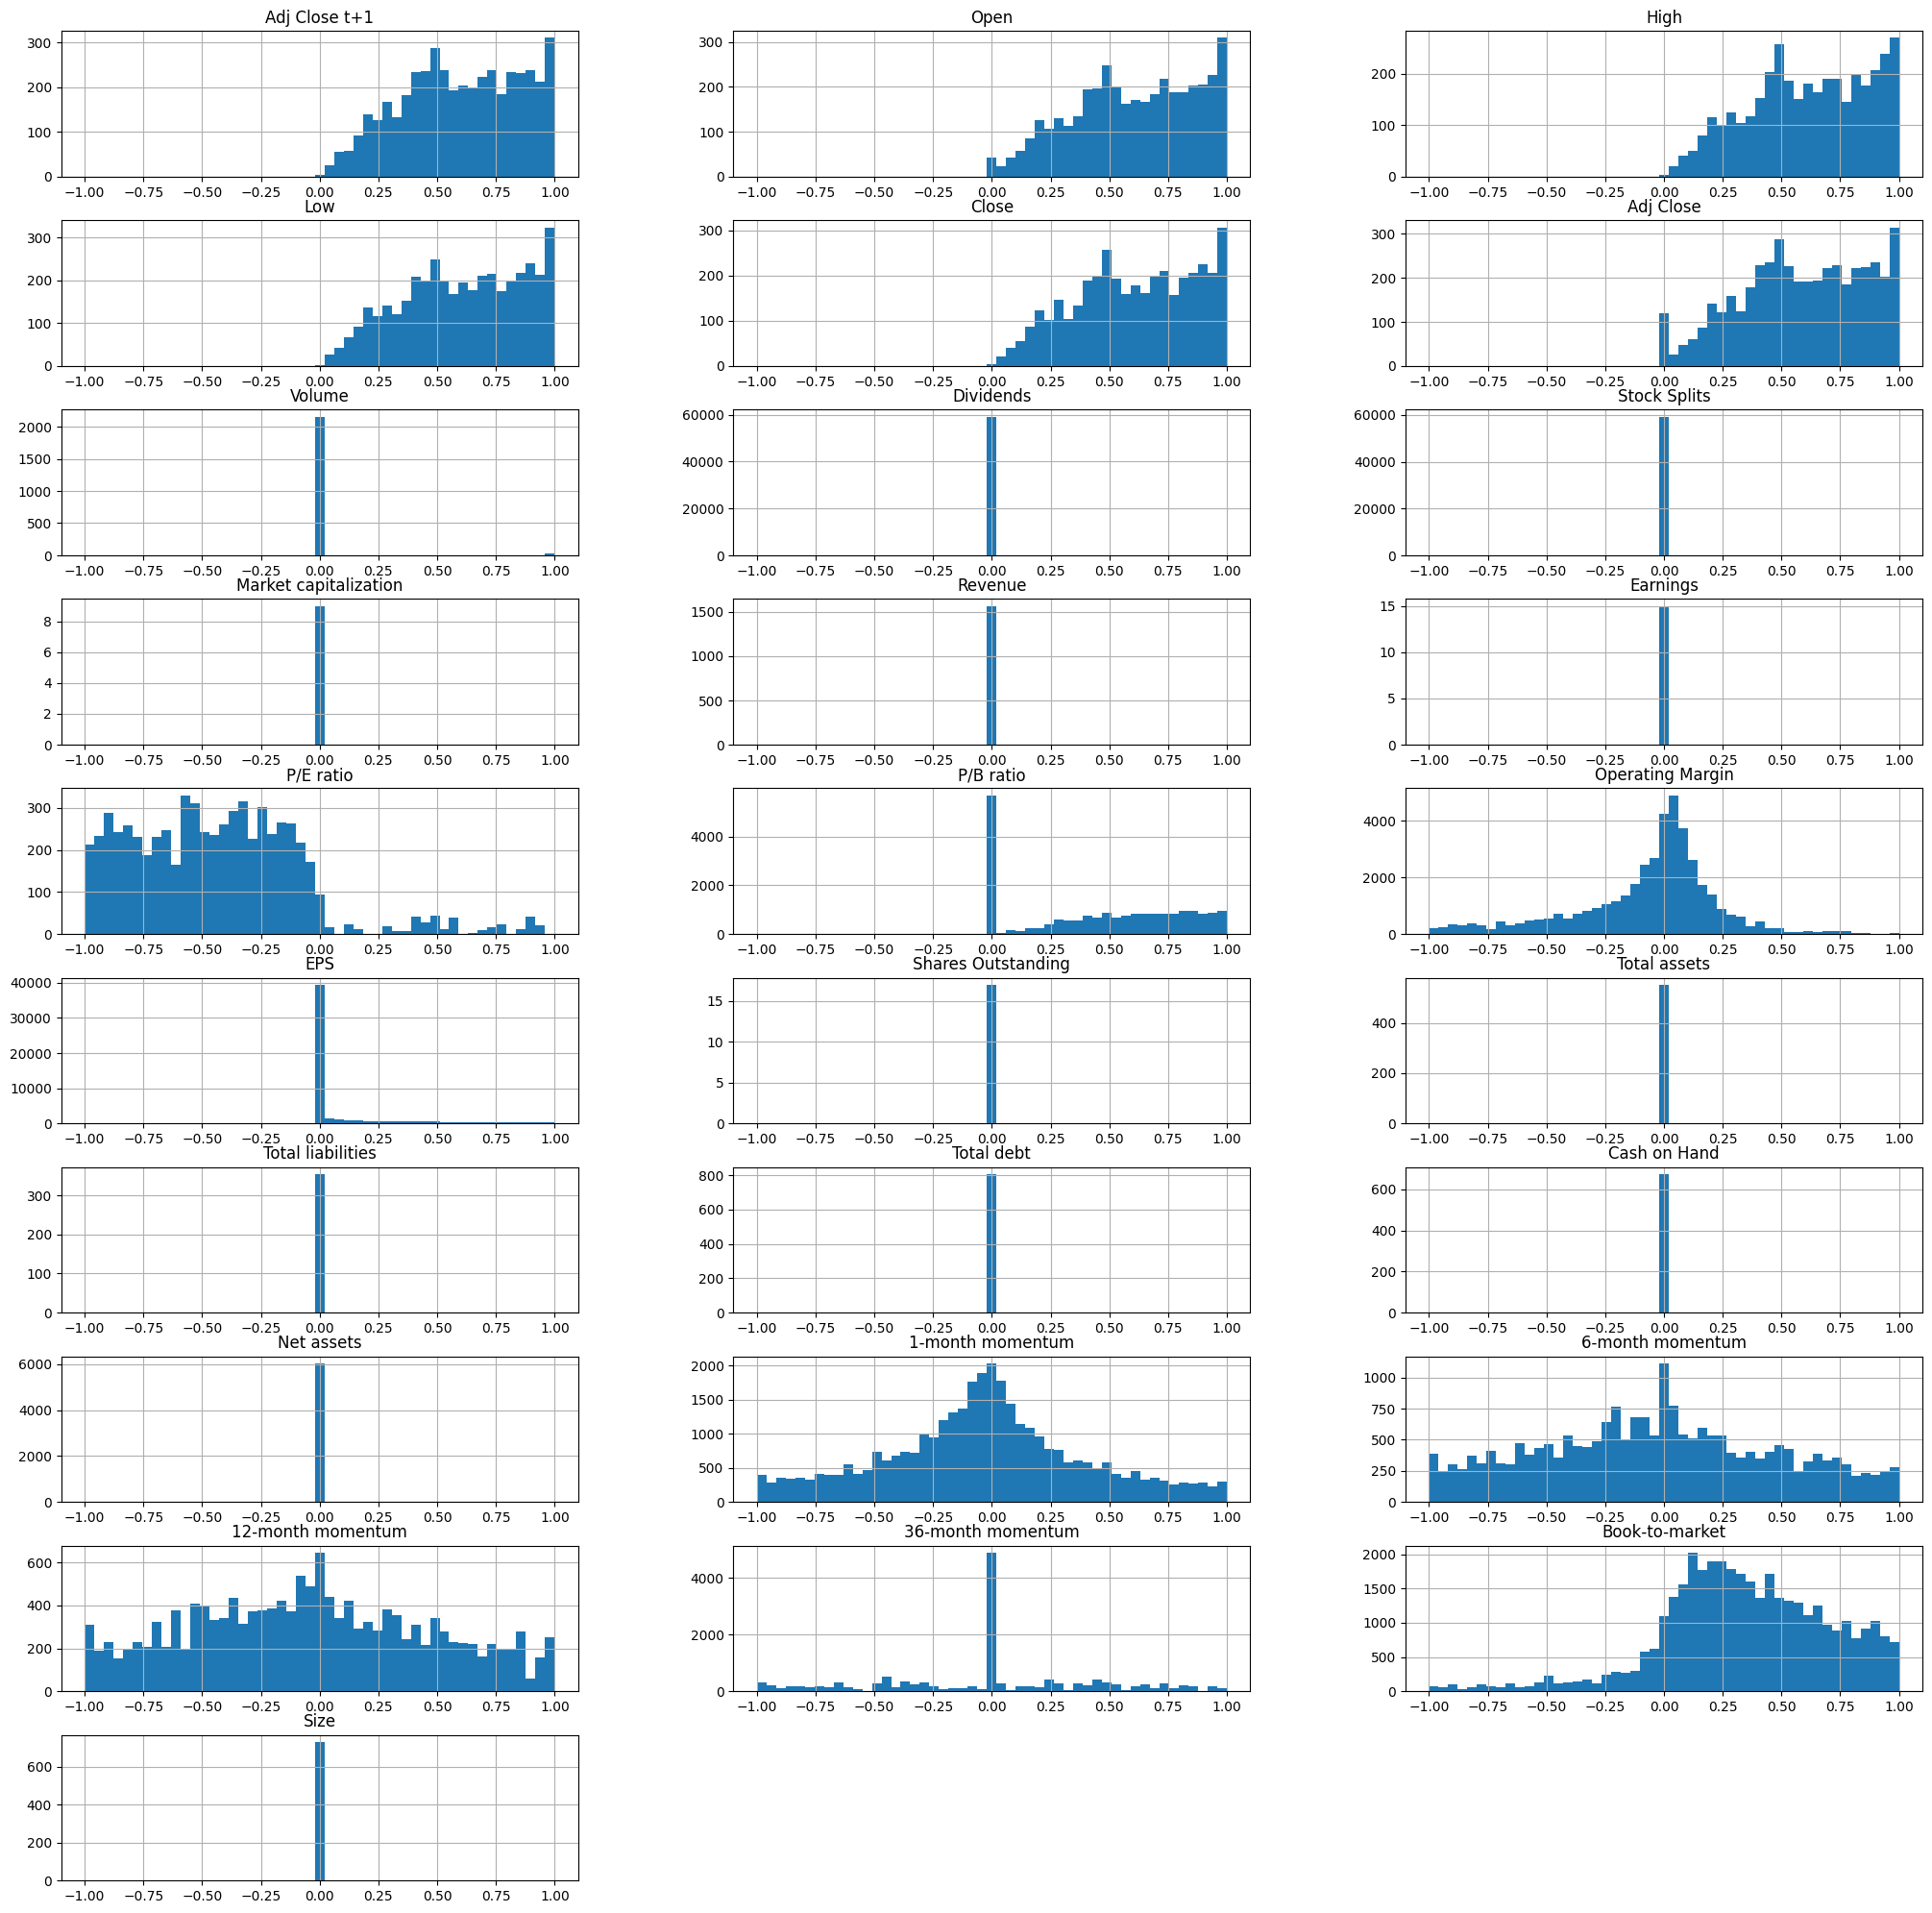

In [16]:
fig, ax = plt.subplots()
fig.set_figheight(25)
fig.set_figwidth(25)
df_bottom_500[variables].hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);

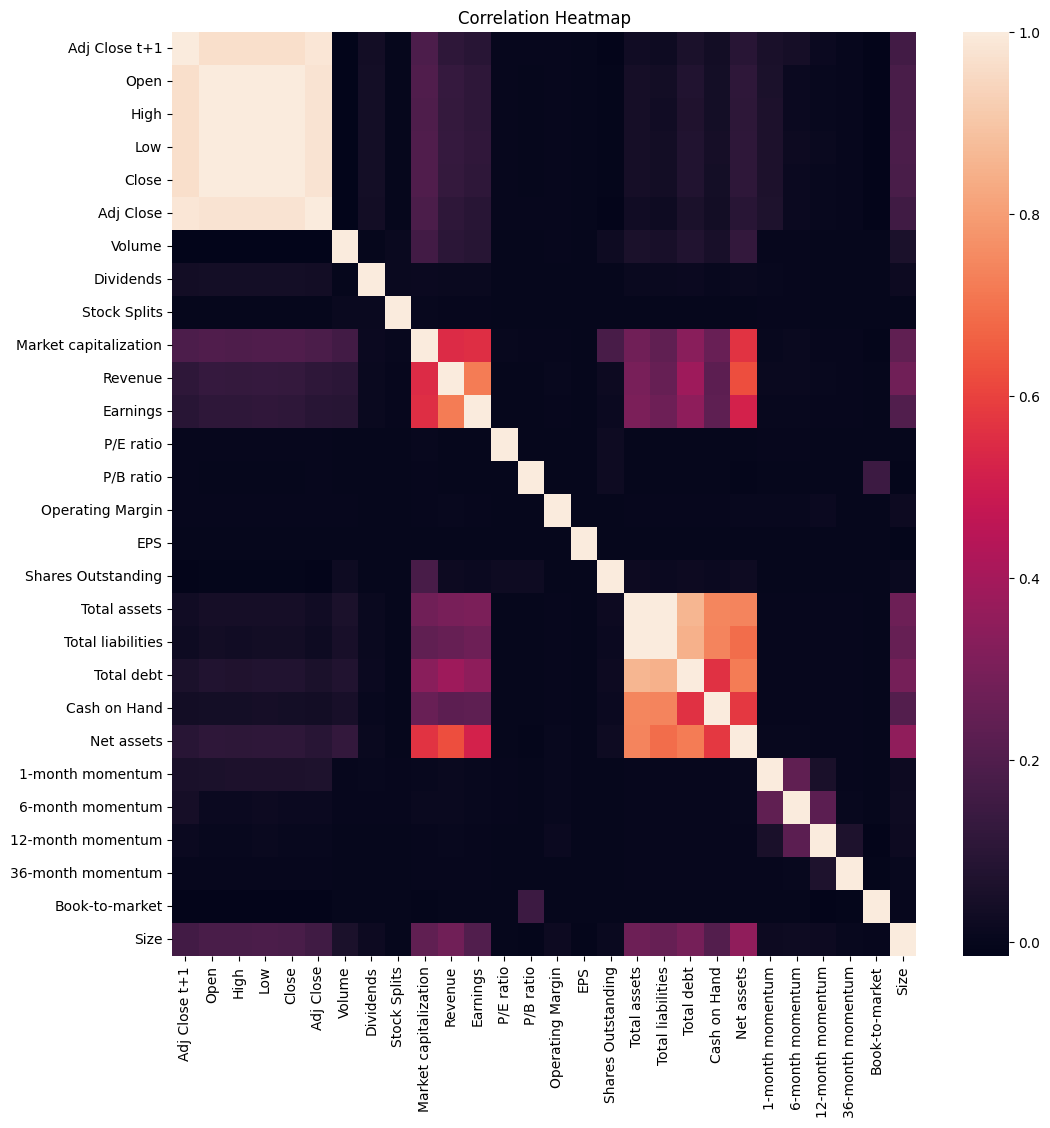

<Figure size 640x480 with 0 Axes>

In [5]:

plt.figure(figsize = (12,12))
sns.heatmap(data=df_final[variables].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

# Comparison of R^2 values

In [148]:
r2oos_OLS = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_OLS.csv")

r2oos_OLS3 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_OLS3.csv")

r2oos_ENet = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_ENet.csv")

r2oos_PCR = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_PCR.csv")

r2oos_PLS = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_PLS.csv")

r2oos_GBRT = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_GBRT.csv")

r2oos_RF = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_RF.csv")


r2oos_NN1 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_NN1.csv")
r2oos_NN2 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_NN2.csv")
r2oos_NN3 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_NN3.csv")
r2oos_NN4 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_NN4.csv")
r2oos_NN5 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_NN5.csv")

In [149]:
dfs = [r2oos_OLS, r2oos_OLS3, r2oos_ENet, r2oos_PCR, r2oos_PLS, r2oos_GBRT, r2oos_RF, r2oos_NN1, r2oos_NN2, r2oos_NN3, r2oos_NN4, r2oos_NN5]

r2oos_df = pd.concat([r2oos_OLS, r2oos_OLS3, r2oos_ENet, r2oos_PCR, r2oos_PLS, r2oos_GBRT, r2oos_RF, r2oos_NN1, r2oos_NN2, r2oos_NN3, r2oos_NN4, r2oos_NN5], axis = 1)

r2oos_df.index = ['Alle', "Øverste 500", "Nederste 500"]

r2oos_df

,OLS +H,OLS-3 +H,ENet +H,PCR,PLS,GBRT +H,RF,NN1,NN2,NN3,NN4,NN5
Alle,0.008282,-0.475333,0.122809,-1.154931,-0.018867,0.086111,0.007568,-29.597616,-123.593161,-191.860178,-309.079248,-116.392150
Øverste 500,0.082616,0.013704,0.018763,0.987986,0.988022,0.709219,0.890111,0.861964,0.759521,0.936402,0.931616,0.782597
Nederste 500,0.076042,-0.005736,0.000010,-18.528054,-0.559758,0.254613,0.006503,-256.360941,-87.708417,-572.743047,-5310.365887,-6883.508516


In [150]:
r2oos_df.transpose()

,Alle,Øverste 500,Nederste 500
OLS +H,0.008282,0.082616,0.076042
OLS-3 +H,-0.475333,0.013704,-0.005736
ENet +H,0.122809,0.018763,0.000010
PCR,-1.154931,0.987986,-18.528054
PLS,-0.018867,0.988022,-0.559758
GBRT +H,0.086111,0.709219,0.254613
RF,0.007568,0.890111,0.006503
NN1,-29.597616,0.861964,-256.360941
NN2,-123.593161,0.759521,-87.708417
NN3,-191.860178,0.936402,-572.743047


# Diebold-Mariano testen

In [14]:
import collections
from scipy.stats import t
from sklearn.utils import check_array
import statsmodels.api as sm

def dm_test(e1, e2, alternative='two_sided', h=1, power=2):
    
    alternatives = ['two_sided', 'less', 'greater']
    if alternative not in alternatives:
        raise ValueError(f"alternative must be one of {alternatives}")

    e1 = check_array(e1, ensure_2d=False)
    e2 = check_array(e2, ensure_2d=False)

    d = np.abs(e1) ** power - np.abs(e2) ** power
    n = d.shape[0]
    d_cov = sm.tsa.acovf(d, fft=True, nlag=h - 1)
    d_var = (d_cov[0] + 2 * d_cov[1:].sum()) / n

    if d_var > 0:
        dm_stat = np.mean(d) / np.sqrt(d_var)
    elif h == 1:
        raise ValueError('Variance of DM statistic is zero')
    else:
        warnings.warn('Variance is negative, using horizon h=1', RuntimeWarning)
        return dm_test(e1, e2, alternative=alternative, h=1, power=power)

    # The corrected statistic suggested by HLN
    k = ((n + 1 - 2 * h + h / n * (h - 1)) / n) ** 0.5
    dm_stat *= k

    if alternative == 'two_sided':
        p_value = 2 * t.cdf(-abs(dm_stat), df=n - 1)
    else:
        p_value = t.cdf(dm_stat, df=n - 1)
        if alternative == 'greater':
            p_value = 1 - p_value

    dm_test_result = collections.namedtuple('dm_test_result', ['dm_stat', 'p_value'])
    return dm_test_result(dm_stat=dm_stat, p_value=p_value)

In [15]:
OLS = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/OLS Estimates")
OLS3 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/OLS3 Estimates")
ENet = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/ENet Estimates")
PLS = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/PLS Estimates")
PCR = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/PCR Estimates")
GBRT = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/GBRT Estimates")
RF = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/RF Estimates")
NN1 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN1 Estimates")
NN2 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN2 Estimates")
NN3 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN3 Estimates")
NN4 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN4 Estimates")
NN5 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN5 Estimates")

FNN2 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/Fake NN2 Estimates")

df_true = OLS[['MonthYear', 'Symbol', 'y_true']]


In [16]:
OLS = OLS.set_index(['MonthYear', 'Symbol'])
OLS3 = OLS3.set_index(['MonthYear', 'Symbol'])
ENet = ENet.set_index(['MonthYear', 'Symbol'])
PLS = PLS.set_index(['MonthYear', 'Symbol'])
PCR = PCR.set_index(['MonthYear', 'Symbol'])
GBRT = GBRT.set_index(['MonthYear', 'Symbol'])
RF = RF.set_index(['MonthYear', 'Symbol'])
NN1 = NN1.set_index(['MonthYear', 'Symbol'])
NN2 = NN2.set_index(['MonthYear', 'Symbol'])
NN3 = NN3.set_index(['MonthYear', 'Symbol'])
NN4 = NN4.set_index(['MonthYear', 'Symbol'])
NN5 = NN5.set_index(['MonthYear', 'Symbol'])

FNN2 = FNN2.set_index(['MonthYear', 'Symbol'])

df_true = df_true.set_index(['MonthYear', 'Symbol'])



In [17]:
OLS = OLS[["y_hat"]]
OLS3 = OLS3[["y_hat"]]
ENet = ENet[["y_hat"]]
PLS = PLS[["y_hat"]]
PCR = PCR[["y_hat"]]
GBRT = GBRT[["y_hat"]]
RF = RF[["y_hat"]]
NN1 = NN1[["y_hat"]]
NN2 = NN2[["y_hat"]]
NN3 = NN3[["y_hat"]]
NN4 = NN4[["y_hat"]]
NN5 = NN5[["y_hat"]]

FNN2 = FNN2[["y_hat"]]




In [18]:
OLS.rename(columns={'y_hat': 'OLS'}, inplace=True)

OLS3.rename(columns={'y_hat': 'OLS3'}, inplace=True)

ENet.rename(columns={'y_hat': 'ENet'}, inplace=True)

PLS.rename(columns={'y_hat': 'PLS'}, inplace=True)

PCR.rename(columns={'y_hat': 'PCR'}, inplace=True)

GBRT.rename(columns={'y_hat': 'GBRT'}, inplace=True)

RF.rename(columns={'y_hat': 'RF'}, inplace=True)

NN1.rename(columns={'y_hat': 'NN1'}, inplace=True)

NN2.rename(columns={'y_hat': 'NN2'}, inplace=True)

NN3.rename(columns={'y_hat': 'NN3'}, inplace=True)

NN4.rename(columns={'y_hat': 'NN4'}, inplace=True)

NN5.rename(columns={'y_hat': 'NN5'}, inplace=True)

FNN2.rename(columns={'y_hat': 'FNN2'}, inplace=True)


In [19]:
models = [OLS, OLS3, ENet,PLS, PCR, GBRT, RF, NN1, NN2, NN3, NN4, NN5, FNN2, df_true]

for df in models:
    df.reset_index(inplace = True)
    
for df in models:
    df["Info"] = df["MonthYear"].astype(str) + df["Symbol"]
    
for df in models:
    df.drop(["MonthYear"], axis=1, inplace=True)
    df.drop(["Symbol"], axis=1, inplace=True)


In [20]:
combined_df = reduce(lambda left, right: pd.merge(left, right, on="Info"), models)


In [21]:
combined_df["MonthYear"] = combined_df["Info"].str[:7]
combined_df["Symbol"] = combined_df["Info"].str[7:]
combined_df.drop(["Info"], axis=1, inplace=True)

In [11]:
# Pr. wikipedia er nævneren af Bonferroni korrektionen givet ved:

(12*11) / 2

66.0

In [23]:
combined_df

,OLS,OLS3,ENet,PLS,PCR,GBRT,RF,NN1,NN2,NN3,NN4,NN5,FNN2,y_true,MonthYear,Symbol
0,4.992034,12.611110,12.904422,19.611570,19.630124,18.683558,19.628932,19.211304,19.381214,19.089781,19.352745,19.679945,16.168262,23.992857,2008-04,A
1,-5.399260,12.621558,11.485472,8.142272,8.190453,7.865482,8.291048,6.848628,6.249227,8.525998,7.902241,7.087276,7.972230,3.733256,2008-04,AAL
2,0.149012,11.241446,6.646299,3.407494,3.417464,3.458090,3.309499,3.166202,3.279678,3.147741,3.223413,3.242928,5.366989,3.544210,2008-04,AAON
3,2.394206,12.768015,13.391428,30.987331,31.049194,30.565983,30.908931,31.150410,31.341480,30.985559,30.723236,31.552408,25.945765,35.527317,2008-04,AAP
4,37.505160,13.858506,16.669675,5.313416,5.380143,5.596627,5.340915,4.064268,6.885767,7.803210,0.448046,11.574212,21.546452,5.692668,2008-04,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510894,0.096583,21.036779,13.426491,1.333593,1.266281,2.231920,1.158489,3.241525,1.004994,1.301421,1.204806,39.144615,14.595528,1.020000,2024-08,ZVIA
510895,-1.696085,26.853306,20.890029,8.005401,8.057638,8.565678,7.655170,6.603068,7.517039,7.746873,7.558702,39.144615,14.291960,7.390000,2024-08,ZVRA
510896,3.874385,29.819199,23.729200,33.171405,33.104973,32.601228,33.380614,30.096451,33.153748,33.080330,33.233730,39.144615,34.525826,32.099998,2024-08,ZWS
510897,0.707669,26.692492,19.269563,12.200171,12.119361,12.685989,12.115855,10.769750,11.845474,11.876691,12.001637,39.144615,20.012079,12.100000,2024-08,ZYME


In [24]:
models = ['OLS', 'OLS3', 'ENet', 'PLS', 'PCR', 'GBRT', 'RF', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'FNN2']

column_name = ['OLS', 'OLS3', 'ENet', 'PLS', 'PCR', 'GBRT', 'RF', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'FNN2']

row_name = ['OLS', 'OLS3', 'ENet', 'PLS', 'PCR', 'GBRT', 'RF', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'FNN2']

bon_kor = 0.05/66 # Bonferroni correction

DM_table = pd.DataFrame(columns = column_name, index = row_name)

for e1 in range(len(models)):
    for e2 in range(len(models)):
        y_true = df_true.y_true
        model1 = models[e1]
        model2 = models[e2]
        
        yhat_model1 = combined_df[model1]
        yhat_model2 = combined_df[model2]
        
        combined_df['ehat_model1'] = y_true - yhat_model1
        combined_df['ehat_model2'] = y_true - yhat_model2
        
        if combined_df['ehat_model1'].tolist() == combined_df['ehat_model2'].tolist():
           DM_table.iloc[e1,e2] = 0 
        
        else:
            result = dm_test(combined_df['ehat_model1'], combined_df['ehat_model2'], alternative='two_sided',  h=1, power=2)
            DM_stat = result[0]
            
            if result[1] <= bon_kor:
                DM_stat = (result[0].astype(str) + "*")
                
            if result[1] <= 0.05:
                DM_stat = (result[0].astype(str) + "**")
            
            DM_table.iloc[e1,e2] = DM_stat
        
        


In [25]:
DM_table

,OLS,OLS3,ENet,PLS,PCR,GBRT,RF,NN1,NN2,NN3,NN4,NN5,FNN2
OLS,0,-2.768811513775445**,-1.698061,-1.788159,-1.761135,-1.205415,-3.1251909292527102**,-1.752974,-1.745735,-1.739854,-1.741781,-1.743528,-2.460296057296737**
OLS3,2.768811513775445**,0,-1.010935,-1.073469,-1.433902,-1.205399,2.4513010051317368**,-1.730657,-1.740291,-1.736347,-1.739598,-1.737742,-2.3604765959501743**
ENet,1.698061,1.010935,0,-0.364989,-1.076502,-1.205384,1.594281,-1.709381,-1.735186,-1.733056,-1.737551,-1.732318,-2.7326988578387406**
PLS,1.788159,1.073469,0.364989,0,-1.737317,-1.205373,1.707133,-1.751769,-1.745389,-1.739602,-1.741631,-1.743142,-1.790567
PCR,1.761135,1.433902,1.076502,1.737317,0,-1.205327,1.723282,-1.75235,-1.745464,-1.739616,-1.741647,-1.743199,-0.978849
GBRT,1.205415,1.205399,1.205384,1.205373,1.205327,0,1.205413,1.204162,1.200308,1.197504,1.192685,1.200616,1.205246
RF,3.1251909292527102**,-2.4513010051317368**,-1.594281,-1.707133,-1.723282,-1.205413,0,-1.750316,-1.745085,-1.739436,-1.741521,-1.742837,-2.432631455847113**
NN1,1.752974,1.730657,1.709381,1.751769,1.75235,-1.204162,1.750316,0,-1.743392,-1.737403,-1.740565,-1.740211,1.519753
NN2,1.745735,1.740291,1.735186,1.745389,1.745464,-1.200308,1.745085,1.743392,0,-1.729205,-1.739131,1.780827,1.690252
NN3,1.739854,1.736347,1.733056,1.739602,1.739616,-1.197504,1.739436,1.737403,1.729205,0,-1.74496,1.734189,1.704197


# Variable importance comparisons

In [26]:
varimp_enet = pd.read_excel(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp ENet.xlsx")

varimp_pcr = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp PCR.csv")

varimp_pls = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp PLS.csv")

varimp_gbrt = pd.read_excel(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp GBRT.xlsx")

varimp_rf = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp RF.csv")

varimp_nn1 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp NN1.csv")

varimp_nn2 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp NN2.csv")

varimp_nn3 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp NN3.csv")

varimp_nn4 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp NN4.csv")

varimp_nn5 = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp NN5.csv")

In [27]:
varimp_enet.rename(columns={'var_imp': 'ENet'}, inplace=True)

varimp_pcr.rename(columns={'var_imp': 'PCR'}, inplace=True)

varimp_pls.rename(columns={'var_imp': 'PLS'}, inplace=True)

varimp_gbrt.rename(columns={'var_imp': 'GBRT'}, inplace=True)

varimp_rf.rename(columns={'var_imp': 'RF'}, inplace=True)

varimp_nn1.rename(columns={'var_imp': 'NN1'}, inplace=True)

varimp_nn2.rename(columns={'var_imp': 'NN2'}, inplace=True)

varimp_nn3.rename(columns={'var_imp': 'NN3'}, inplace=True)

varimp_nn4.rename(columns={'var_imp': 'NN4'}, inplace=True)

varimp_nn5.rename(columns={'var_imp': 'NN5'}, inplace=True)

In [28]:
varimp_dfs = [varimp_enet, varimp_pcr, varimp_pls, varimp_gbrt, varimp_rf, varimp_nn1, varimp_nn2, varimp_nn3, varimp_nn4, varimp_nn5]
var_imp_all = reduce(lambda left, right: pd.merge(left, right, on="Variable"), varimp_dfs)

var_imp_all = var_imp_all.set_index("Variable")


In [29]:
var_imp_all

,ENet,PCR,PLS,GBRT,RF,NN1,NN2,NN3,NN4,NN5
Variable,,,,,,,,,,
Adj Close,0.085872,0.065651,6.211680e-01,0.129880,6.919504e-01,1.0,1.022497e+00,0.993522,0.992301,1.0
High,0.160416,0.014645,1.542248e-01,0.283348,1.567369e-02,0.0,1.518834e-03,0.001193,0.000000,0.0
Low,0.131918,0.000458,1.498873e-01,0.001340,1.243872e-01,0.0,1.576444e-03,0.002353,0.000000,0.0
Close,0.152609,0.000001,4.083969e-02,0.068378,1.607485e-02,0.0,3.352352e-03,0.001461,0.005683,0.0
Open,0.133159,0.000475,3.397593e-02,0.008841,1.426008e-01,0.0,2.031314e-03,0.000718,0.002016,0.0
Size,0.000000,0.038163,1.304614e-04,0.001109,-2.544487e-03,0.0,-5.019066e-05,0.000134,0.000000,0.0
Net assets,0.000000,0.039163,4.794879e-06,0.010731,-3.256880e-03,0.0,-1.797437e-05,0.000312,0.000000,0.0
Earnings,0.070413,0.039200,4.097239e-06,0.012934,-1.873986e-03,0.0,-5.136759e-05,-0.000052,0.000000,0.0
Shares Outstanding,0.040563,0.039163,3.987492e-06,0.034755,3.551014e-03,0.0,-3.959094e-05,-0.000025,0.000000,0.0


In [30]:

var_imp_all['rank_ENet'] = pd.factorize(var_imp_all['ENet'], sort=True)[0] + 1

var_imp_all['rank_PCR'] = pd.factorize(var_imp_all['PCR'], sort=True)[0] + 1

var_imp_all['rank_PLS'] = pd.factorize(var_imp_all['PLS'], sort=True)[0] + 1

var_imp_all['rank_GBRT'] = pd.factorize(var_imp_all['GBRT'], sort=True)[0] + 1

var_imp_all['rank_RF'] = pd.factorize(var_imp_all['RF'], sort=True)[0] + 1

var_imp_all['rank_NN1'] = pd.factorize(var_imp_all['NN1'], sort=True)[0] + 1

var_imp_all['rank_NN2'] = pd.factorize(var_imp_all['NN2'], sort=True)[0] + 1

var_imp_all['rank_NN3'] = pd.factorize(var_imp_all['NN3'], sort=True)[0] + 1

var_imp_all['rank_NN4'] = pd.factorize(var_imp_all['NN4'], sort=True)[0] + 1

var_imp_all['rank_NN5'] = pd.factorize(var_imp_all['NN5'], sort=True)[0] + 1





In [31]:
var_imp_all = var_imp_all.iloc[:, 10:] 
var_imp_all.rename(columns=lambda x: x.replace('rank_', ''), inplace=True)


var_imp_all["sum"] = var_imp_all.sum(axis=1)  
var_imp_all = var_imp_all.sort_values(by=['sum'], ascending=True)  
var_imp_all = var_imp_all.iloc[:, :-1]  


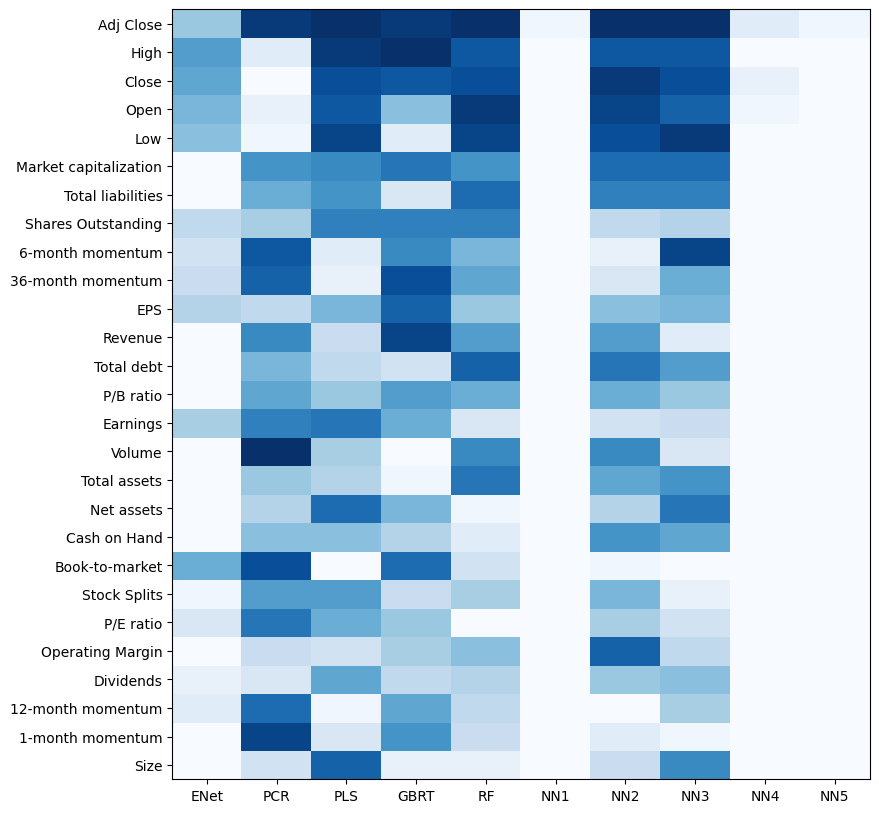

In [36]:
plt.rcParams["figure.figsize"] = (9, 10)
plt.pcolor(var_imp_all, cmap="Blues")
plt.yticks(np.arange(0.5, len(var_imp_all.index), 1), var_imp_all.index)
plt.xticks(np.arange(0.5, len(var_imp_all.columns), 1), var_imp_all.columns)
plt.plot(figsize=(20, 10))
plt.savefig('Characteristic importance.png')
plt.show()


# Cumulative expecred returns graphs

In [88]:
ols3_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/OLS3 eq.csv", index_col = "MonthYear_long")
ols3_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/OLS3 mc.csv", index_col = "MonthYear_long")

pls_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/PLS eq.csv", index_col = "MonthYear_long")
pls_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/PLS mc.csv", index_col = "MonthYear_long")

pcr_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/PCR eq.csv", index_col = "MonthYear_long")
pcr_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/PCR mc.csv", index_col = "MonthYear_long")

enet_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/ENet eq.csv", index_col = "MonthYear_long")
enet_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/ENet mc.csv", index_col = "MonthYear_long")

rf_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/RF eq.csv", index_col = "MonthYear_long")
rf_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/RF mc.csv", index_col = "MonthYear_long")

gbrt_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/GBRT eq.csv", index_col = "MonthYear_long")
gbrt_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/GBRT mc.csv", index_col = "MonthYear_long")

nn4_eq = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/NN4 eq.csv", index_col = "MonthYear_long")
nn4_mc = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/NN4 mc.csv", index_col = "MonthYear_long")

In [89]:
ols3_eq.rename(columns={"cum_log_exc_ret_eq_long": "ols3_long",
                        
                        "cum_log_exc_ret_eq_short": "ols3_short"}, inplace=True)
ols3_eq.index.rename('year-month', inplace=True)


pls_eq.rename(columns={"cum_log_exc_ret_eq_long": "pls_long",
                        
                        "cum_log_exc_ret_eq_short": "pls_short"}, inplace=True)
pls_eq.index.rename('year-month', inplace=True)



pcr_eq.rename(columns={"cum_log_exc_ret_eq_long": "pcr_long",
                        
                        "cum_log_exc_ret_eq_short": "pcr_short"}, inplace=True)
pcr_eq.index.rename('year-month', inplace=True)




enet_eq.rename(columns={"cum_log_exc_ret_eq_long": "enet_long",
                        
                        "cum_log_exc_ret_eq_short": "enet_short"}, inplace=True)
enet_eq.index.rename('year-month', inplace=True)



rf_eq.rename(columns={"cum_log_exc_ret_eq_long": "rf_long",
                        
                        "cum_log_exc_ret_eq_short": "rf_short"}, inplace=True)
rf_eq.index.rename('year-month', inplace=True)


gbrt_eq.rename(columns={"cum_log_exc_ret_eq_long": "gbrt_long",
                        
                        "cum_log_exc_ret_eq_short": "gbrt_short"}, inplace=True)
gbrt_eq.index.rename('year-month', inplace=True)



nn4_eq.rename(columns={"cum_log_exc_ret_eq_long": "nn4_long",
                        
                        "cum_log_exc_ret_eq_short": "nn4_short"}, inplace=True)
nn4_eq.index.rename('year-month', inplace=True)

In [90]:

ols3_mc.rename(columns={"cum_log_exc_ret_mc_long": "ols3_long",
                        
                        "cum_log_exc_ret_mc_short": "ols3_short"}, inplace=True)
ols3_mc.index.rename('year-month', inplace=True)



pls_mc.rename(columns={"cum_log_exc_ret_mc_long": "pls_long",
                        
                        "cum_log_exc_ret_mc_short": "pls_short"}, inplace=True)
pls_mc.index.rename('year-month', inplace=True)


pcr_mc.rename(columns={"cum_log_exc_ret_mc_long": "pcr_long",
                        
                        "cum_log_exc_ret_mc_short": "pcr_short"}, inplace=True)
pcr_mc.index.rename('year-month', inplace=True)



enet_mc.rename(columns={"cum_log_exc_ret_mc_long": "enet_long",
                        
                        "cum_log_exc_ret_mc_short": "enet_short"}, inplace=True)
enet_mc.index.rename('year-month', inplace=True)




rf_mc.rename(columns={"cum_log_exc_ret_mc_long": "rf_long",
                        
                        "cum_log_exc_ret_mc_short": "rf_short"}, inplace=True)
rf_mc.index.rename('year-month', inplace=True)




gbrt_mc.rename(columns={"cum_log_exc_ret_mc_long": "gbrt_long",
                        
                        "cum_log_exc_ret_mc_short": "gbrt_short"}, inplace=True)
gbrt_mc.index.rename('year-month', inplace=True)




nn4_mc.rename(columns={"cum_log_exc_ret_mc_long": "nn4_long",
                        
                        "cum_log_exc_ret_mc_short": "nn4_short"}, inplace=True)
nn4_mc.index.rename('year-month', inplace=True)


In [93]:
eq_df = pd.concat([ols3_eq, pls_eq, pcr_eq, enet_eq, rf_eq, gbrt_eq, nn4_eq], axis=1)

eq_df

,ols3_long,ols3_short,pls_long,pls_short,pcr_long,pcr_short,enet_long,enet_short,rf_long,rf_short,gbrt_long,gbrt_short,nn4_long,nn4_short
year-month,,,,,,,,,,,,,,
2014-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02,0.077729,0.055358,0.100257,0.027555,0.093705,0.028929,0.073566,0.057603,0.103954,0.031817,0.093379,0.037911,0.105660,0.042034
2014-03,0.099748,0.026108,0.157047,-0.037589,0.143606,-0.032771,0.093438,0.027566,0.163212,-0.010772,0.143281,-0.007543,0.182932,-0.029154
2014-04,0.100771,-0.033856,0.173728,-0.118058,0.155178,-0.113504,0.094018,-0.032294,0.198549,-0.108978,0.158505,-0.085190,0.216998,-0.128529
2014-05,0.112264,-0.047947,0.188590,-0.146708,0.170040,-0.142154,0.103397,-0.035872,0.238887,-0.138443,0.164395,-0.096670,0.263211,-0.162409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,7.364325,-2.650155,11.224536,-5.971961,11.253682,-6.086529,6.716664,-0.227858,9.679243,-2.677444,9.893947,-4.992827,12.783536,-5.134140
2023-09,7.322290,-2.750802,11.199039,-6.064758,11.225670,-6.177996,6.678481,-0.295004,9.671500,-2.762759,9.873820,-5.085490,12.748001,-5.218731
2023-10,7.208174,-2.865078,11.084973,-6.183415,11.111097,-6.291028,6.565235,-0.361576,9.596828,-2.899071,9.760214,-5.182099,12.626954,-5.323416


In [94]:
mc_df = pd.concat([ols3_mc, pls_mc, pcr_mc, enet_mc, rf_mc, gbrt_mc, nn4_mc], axis=1)

mc_df

,ols3_long,ols3_short,pls_long,pls_short,pcr_long,pcr_short,enet_long,enet_short,rf_long,rf_short,gbrt_long,gbrt_short,nn4_long,nn4_short
year-month,,,,,,,,,,,,,,
2014-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02,0.035512,0.036678,0.050845,0.022750,0.033980,0.024357,0.032967,0.061239,0.099506,0.007283,0.061740,0.024730,0.026798,0.036082
2014-03,0.053404,0.011504,0.067754,-0.014875,0.070690,-0.028984,0.058497,0.015517,0.077030,-0.017312,0.115176,-0.011946,0.060313,0.033603
2014-04,0.065937,-0.012473,0.082769,-0.016982,0.101270,-0.045224,0.091642,-0.016229,0.126480,-0.031161,0.159154,-0.046768,0.072186,0.025908
2014-05,0.077694,-0.003772,0.104210,-0.024766,0.122712,-0.053007,0.103172,0.011290,0.161757,-0.022480,0.164024,-0.041417,0.092832,0.026818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,0.769828,-1.458276,4.371686,-3.750487,6.655831,-4.651082,1.955881,0.467565,4.505448,-2.206217,2.831979,-2.366584,3.220595,-1.993755
2023-09,0.717356,-1.516118,4.315727,-3.789316,6.599201,-4.672219,1.911620,0.419725,4.461545,-2.283381,2.772133,-2.422695,3.218726,-2.010568
2023-10,0.649953,-1.551118,4.205661,-3.854008,6.485898,-4.723582,1.816193,0.384793,4.452757,-2.356303,2.666829,-2.472216,3.153390,-2.069721


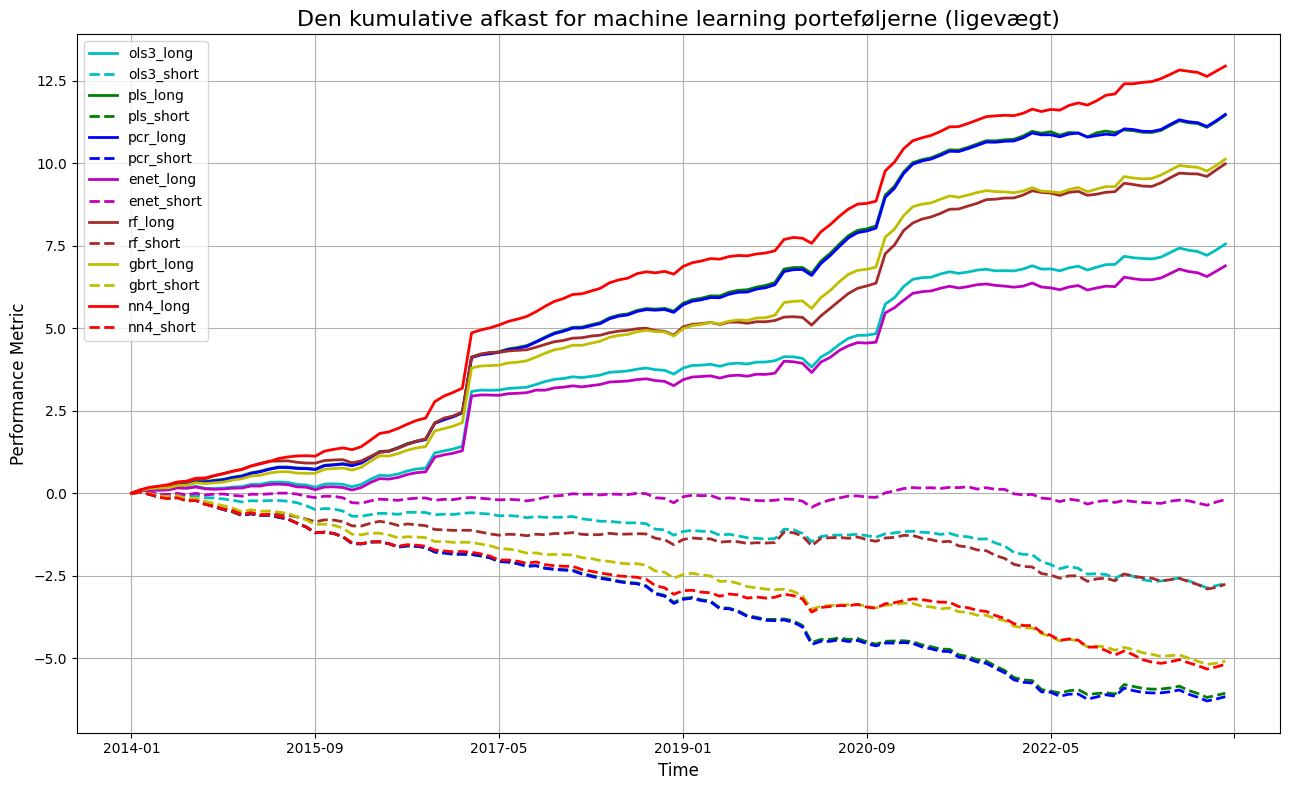

In [ ]:

style_dict = {
    'ols3_long': {'color': 'c', 'linestyle': '-'},  
    'ols3_short': {'color': 'c', 'linestyle': '--'}, 
    'pls_long': {'color': 'g', 'linestyle': '-'},  
    'pls_short': {'color': 'g', 'linestyle': '--'}, 
    'pcr_long': {'color': 'b', 'linestyle': '-'},  
    'pcr_short': {'color': 'b', 'linestyle': '--'},  
    'enet_long': {'color': 'm', 'linestyle': '-'},  
    'enet_short': {'color': 'm', 'linestyle': '--'},  
    'rf_long': {'color': 'brown', 'linestyle': '-'},  
    'rf_short': {'color': 'brown', 'linestyle': '--'},  
    'gbrt_long': {'color': 'y', 'linestyle': '-'},  
    'gbrt_short': {'color': 'y', 'linestyle': '--'},  
    'nn4_long': {'color': 'red', 'linestyle': '-'},  
    'nn4_short': {'color': 'red', 'linestyle': '--'}, 
}


plt.figure(figsize=(13, 8))

for col in eq_df.columns:
    style = style_dict.get(col, {'color': 'k', 'linestyle': '-'}) 
    eq_df[col].plot(
        linestyle=style['linestyle'],
        color=style['color'],
        label=col,
        linewidth=2
    )

plt.grid(True)
plt.title("Den kumulative afkast for machine learning porteføljerne (lige-vægtet)", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Performance Metric", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

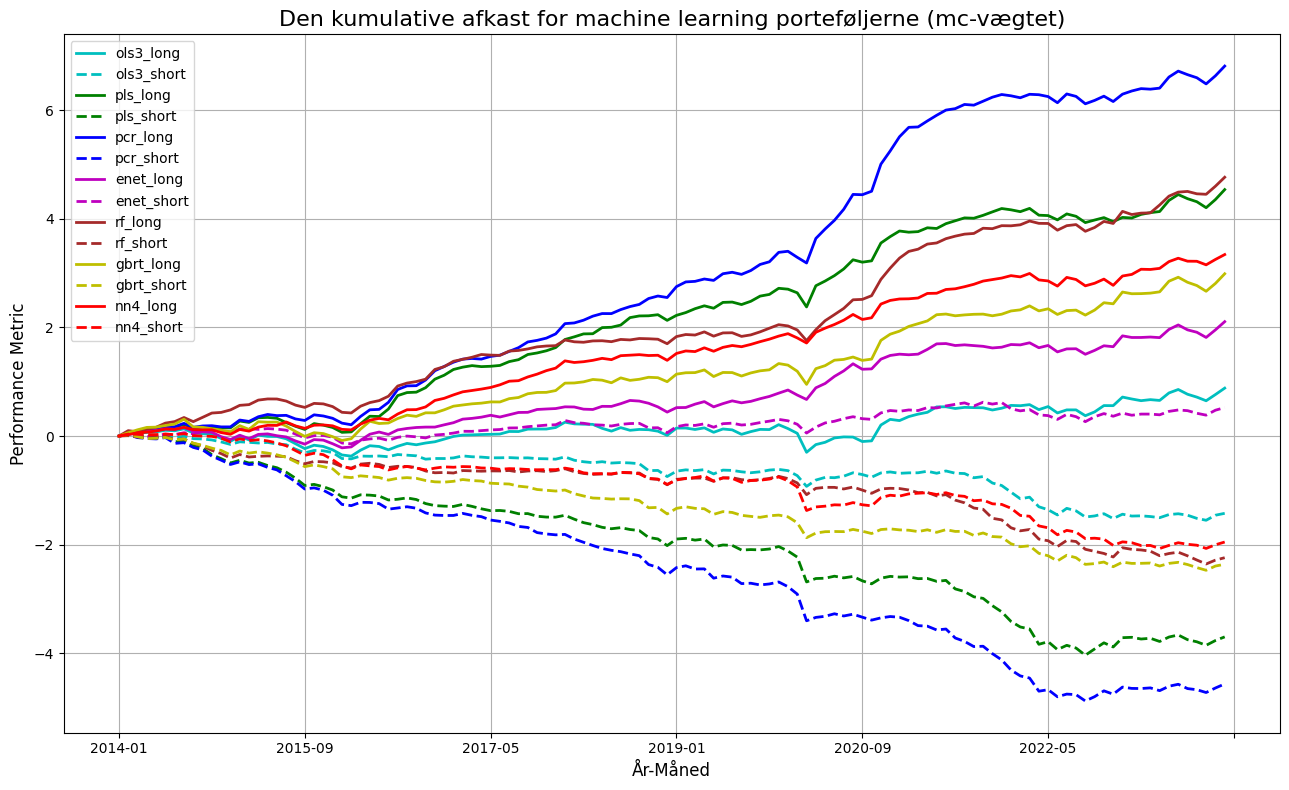

In [111]:
plt.figure(figsize=(13, 8))

for col in mc_df.columns:
    style = style_dict.get(col, {'color': 'k', 'linestyle': '-'}) 
    mc_df[col].plot(
        linestyle=style['linestyle'],
        color=style['color'],
        label=col,
        linewidth=2
    )

plt.grid(True)
plt.title("Den kumulative afkast for machine learning porteføljerne (mc-vægtet)", fontsize=16)
plt.xlabel("År-Måned", fontsize=12)
plt.ylabel("Performance Metric", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Tabels of the machine learning portfolios

In [11]:
ols3_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/OLS3_eq.csv", index_col=0).round(3)
ols3_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/OLS3_mc.csv", index_col=0).round(3)

pls_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/PLS_eq.csv", index_col=0).round(3)
pls_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/PLS_mc.csv", index_col=0).round(3)

pcr_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/PCR_eq.csv", index_col=0).round(3)
pcr_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/PCR_mc.csv", index_col=0).round(3)

enet_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/ENet_eq.csv", index_col=0).round(3)
enet_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/ENet_mc.csv", index_col=0).round(3)

ols_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/OLS_eq.csv", index_col=0).round(3)
ols_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/OLS_mc.csv", index_col=0).round(3)

rf_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/RF_eq.csv", index_col=0).round(3)
rf_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/RF_mc.csv", index_col=0).round(3)

gbrt_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/GBRT_eq.csv", index_col=0).round(3)
gbrt_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/GBRT_mc.csv", index_col=0).round(3)

nn1_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN1_eq.csv", index_col=0).round(3)
nn1_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN1_mc.csv", index_col=0).round(3)

nn2_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN2_eq.csv", index_col=0).round(3)
nn2_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN2_mc.csv", index_col=0).round(3)

nn3_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN3_eq.csv", index_col=0).round(3)
nn3_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN3_mc.csv", index_col=0).round(3)

nn4_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN4_eq.csv", index_col=0).round(3)
nn4_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN4_mc.csv", index_col=0).round(3)

nn5_eq_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN5_eq.csv", index_col=0).round(3)
nn5_mc_port = pd.read_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN5_mc.csv", index_col=0).round(3)


In [21]:
df_eq_1 = (
    ols3_mc_port.merge(pls_mc_port, left_index=True, right_index=True, how='inner')
       .merge(pcr_mc_port, left_index=True, right_index=True, how='inner')
)

In [22]:
df_eq_2 = (
    enet_mc_port.merge(ols_mc_port, left_index=True, right_index=True, how='inner')
       .merge(rf_mc_port, left_index=True, right_index=True, how='inner')
       )

In [23]:
df_eq_3 = (
    gbrt_mc_port.merge(nn1_mc_port, left_index=True, right_index=True, how='inner')
       .merge(nn2_mc_port, left_index=True, right_index=True, how='inner'))

In [24]:
df_eq_4 = (
    nn3_mc_port.merge(nn4_mc_port, left_index=True, right_index=True, how='inner')
       .merge(nn5_mc_port, left_index=True, right_index=True, how='inner'))

In [28]:
df_eq_4

,Pred Avg_x,True Avg_x,SD_x,SR_x,Pred Avg_y,True Avg_y,SD_y,SR_y,Pred Avg,True Avg,SD,SR
Low(L),-0.155,-0.011,0.054,-0.728,-0.168,-0.014,0.060,-0.836,-0.296,-0.003,0.049,-0.200
1,-0.065,-0.013,0.053,-0.871,-0.067,-0.009,0.055,-0.591,-0.183,-0.007,0.051,-0.494
2,-0.043,-0.009,0.048,-0.657,-0.044,-0.007,0.051,-0.475,-0.129,-0.007,0.048,-0.523
3,-0.027,-0.003,0.047,-0.219,-0.028,-0.000,0.046,-0.000,-0.078,-0.002,0.046,-0.114
4,-0.015,0.004,0.045,0.273,-0.016,0.004,0.045,0.323,-0.016,0.005,0.049,0.321
5,-0.003,0.013,0.046,0.944,-0.005,0.011,0.044,0.830,0.061,0.009,0.052,0.587
6,0.009,0.018,0.047,1.339,0.007,0.017,0.046,1.270,0.178,0.014,0.055,0.895
7,0.024,0.029,0.050,1.991,0.023,0.027,0.049,1.941,0.354,0.023,0.060,1.331
8,0.053,0.040,0.060,2.278,0.062,0.033,0.053,2.164,0.762,0.027,0.062,1.495
High(H),0.406,0.038,0.076,1.740,0.490,0.030,0.066,1.587,2.111,0.025,0.076,1.158
